In [131]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [132]:
import pandas as pd
import numpy as np
from pprint import pprint as pp

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

In [135]:
from pycaret.classification import *

In [136]:
from helper_methods import make_dataframes_from_classification_report
from helper_methods import print_info_from_pycaret_setup
from helper_methods import find_dataframes_series_from_pycaret_setup, find_train_test_data_from_pycaret_setup

# CAPSTONE PROTOTYPE INFORMATION
This notebook has 2 logical variables relevant to prototyping:

`use_small_dataset`   
when `True`: only 13,000 records from the full dataset are used

`running_on_local_machine`   
when `False`: using Paperspace machine   
used to set name of directories for reading and writing files

The results in the notebook are for the small dataset running on my own computer.

# OBJECTIVE
Feature `soil_index` is non-ordinal, categorical with 40 values. Each value has a particular ecological meaning. Each value is associated with a climatic zone (7 possibilities) and a geologic zone (4 possibilities.) These zones provide a domain informed way to cluster the 40 values. The purpose of this work is to investigate how different techniques for handling this feature impact the performance of several models.

The techniques investigated are
- one-hot encoding
- frequency encoding
- climatic zone clustering
- geologic zone clustering
- climatic + geologic zone clustering (11 combinations are present in the data)

These models are investigated using `pycaret`:
- logistic regression
- decision tree
- XGBoost
- LightGBM (uses categorical features directly)
- CatBoost (uses categorical features directly)

For LightGBM and CatBoost,the category values (original, climatic zone, etc.) are used directly; they are not one-hot encoded. For all other models, the original values and the cluster values are one-hot encoded.

Model hyper-parameters:
- 70-30 train-test split
- 3-fold cross validation
- defaults for all others

# preamble
### logical to control dataset sizes for modeling
##### `True` gives very small train and test set sizes for developing and debugging notebook
##### `False` splits entire dataset into train and test

In [137]:
#use_small_data_set = True
use_small_data_set = False

### pickle file name

In [138]:
#running_on_local_machine = True
running_on_local_machine = False

if running_on_local_machine:
    pickle_file_name = 'data/wrangled_data_update_soil.pkl'
    pycaret_results_dir = 'pycaret_df_results/'
else:
    pickle_file_name = '/storage/wrangled_data_update_soil.pkl'
    pycaret_results_dir = '/storage/pycaret_df_results/'

# read wrangled data from pickle

In [139]:
df_data = pd.read_pickle(pickle_file_name)

In [140]:
df_data.shape
df_data.columns
df_data.head()

(581012, 71)

Index(['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology',
       'HD_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'HD_fire_points', 'wild_area_rawah', 'wild_area_neota',
       'wild_area_comanche_peak', 'wild_area_cache_la_poudre', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_35', 'soil_type_36', 'soil_type_37',
       'soil_type_38', 'soil_type_39', 'soil_type_40', 'cover_type',
       'wilder

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,...,mms_elevation,mms_aspect,mms_slope,mms_HD_hydrology,mms_VD_hydrology,mms_HD_roadways,mms_hillshade_9am,mms_hillshade_noon,mms_hillshade_3pm,mms_HD_fire_points
0,2596,51,3,258,0,510,221,232,148,6279,...,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366
1,2590,56,2,212,-6,390,220,235,151,6225,...,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838
2,2804,139,9,268,65,3180,234,238,135,6121,...,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339
3,2785,155,18,242,118,3090,238,238,122,6211,...,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886
4,2595,45,2,153,-1,391,220,234,150,6172,...,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449


### define lists of column names

In [141]:
column = 'wild_area_'
areas = ['rawah', 'neota', 'comanche_peak', 'cache_la_poudre']
wild_area_cols = []
for i in areas:
    wild_area_cols.append(column + i)

column = 'soil_type_'
soil_type_cols = []
for i in range(1,41):
    soil_type_cols.append(column + str(i))

numerical_cols = ['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology', 'HD_roadways',
                  'hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 'HD_fire_points']

scaled_numerical_cols = []
for col in numerical_cols:
    scaled_numerical_cols.append('mms_' + col)

target_col = ['cover_type']

target_names = ['spruce_fir', 'lodgepole_pine', 'ponderosa_pine', 'cottonwood_willow', 'aspen', 'douglas_fir', 'krummholz']

reverse_one_hot_cols = ['wilderness_index', 'wilderness_area', 'soil_index']

soil_cluster_cols = ['climatic_zone', 'geologic_zone', 'both_zones']

print('numerical_cols:')
pp(numerical_cols)

print('\nscaled_numerical_cols:')
pp(scaled_numerical_cols)

print('\nwild_area_cols:')
pp(wild_area_cols)

print('\nsoil_type_cols:')
pp(soil_type_cols)

print('\nsoil_cluster_cols:')
pp(soil_cluster_cols)

print('\nreverse_one_hot_cols:')
pp(reverse_one_hot_cols)

print('\ntarget_col:')
pp(target_col)

print('\ntarget_names:')
pp(target_names)

numerical_cols:
['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points']

scaled_numerical_cols:
['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points']

wild_area_cols:
['wild_area_rawah',
 'wild_area_neota',
 'wild_area_comanche_peak',
 'wild_area_cache_la_poudre']

soil_type_cols:
['soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6',
 'soil_type_7',
 'soil_type_8',
 'soil_type_9',
 'soil_type_10',
 'soil_type_11',
 'soil_type_12',
 'soil_type_13',
 'soil_type_14',
 'soil_type_15',
 'soil_type_16',
 'soil_type_17',
 'soil_type_18',
 'soil_type_19',
 'soil_type_20',
 'soil_type_21',
 'soil_type_22',
 'soil_type_23',
 'soil_type_24',
 'soil_type_25',
 'soil_type_26',
 'soil_type_27',
 'soil_type_28',
 's

In [142]:
len(df_data.columns)

71

In [143]:
len(numerical_cols + scaled_numerical_cols + wild_area_cols
    + soil_type_cols + reverse_one_hot_cols + target_col + soil_cluster_cols)

71

# function to build feature columns list

In [144]:
def make_feature_columns_list(numerical_scaled, wild_area_one_hot, soil_type_one_hot, soil_type_cluster='none'):
    feature_cols_list = []
    
    if numerical_scaled:
        feature_cols_list += scaled_numerical_cols
    else:
        feature_cols_list += numerical_cols
    
    if wild_area_one_hot:
        feature_cols_list += wild_area_cols
    else:
        feature_cols_list.append(reverse_one_hot_cols[0])
    
    if soil_type_one_hot:
        feature_cols_list += soil_type_cols
    elif soil_type_cluster=='none':
        feature_cols_list.append(reverse_one_hot_cols[2])
    elif soil_type_cluster=='climatic':
        feature_cols_list.append(soil_cluster_cols[0])
    elif soil_type_cluster=='geologic':
        feature_cols_list.append(soil_cluster_cols[1])
    elif soil_type_cluster=='both':
        feature_cols_list.append(soil_cluster_cols[2])
    else:
        print('ERROR ERROR ERROR ERROR in selection of soil type columns')
    
    return feature_cols_list

In [145]:
temp_list = make_feature_columns_list(numerical_scaled=True, wild_area_one_hot=False,
                                      soil_type_one_hot=False, soil_type_cluster='both')
pp(temp_list)

['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points',
 'wilderness_index',
 'both_zones']


# function to get target name from target integer value

In [146]:
get_target_name_from_integer = lambda i : target_names[i-1]
get_target_name_from_integer(2)

'lodgepole_pine'

# select columns

In [147]:
feature_cols_all = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                                soil_type_one_hot=False, soil_type_cluster='none')
feature_cols_all += soil_cluster_cols
feature_cols_all

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'soil_index',
 'climatic_zone',
 'geologic_zone',
 'both_zones']

# train-test split

In [148]:
if use_small_data_set:
    train_sample_size = 10000
    test_sample_size  = 3000

    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols_all], df_data[target_col[0]],
                                       train_size=train_sample_size, test_size=test_sample_size, random_state=59)

else:
    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols_all], df_data[target_col[0]],
                                       train_size=0.7, random_state=59)
    

In [149]:
X_train.shape
X_test.shape

(406708, 15)

(174304, 15)

### make dataframe with test and train

In [150]:
df_data_to_use = (pd.concat([X_train, y_train], axis=1)).append(pd.concat([X_test, y_test], axis=1))
df_data_to_use.shape
df_data_to_use.head()

(581012, 16)

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wilderness_index,soil_index,climatic_zone,geologic_zone,both_zones,cover_type
511216,3153,67,16,256,21,1368,235,206,98,2372,2,39,8,7,87,1
234324,2738,186,17,30,5,1243,220,250,157,1950,2,13,4,7,47,1
446270,3238,13,4,467,203,2816,215,231,152,2942,2,31,7,7,77,1
50042,2759,331,6,124,2,2249,206,233,165,3955,0,12,4,7,47,2
549678,3414,234,21,60,0,2121,180,253,205,3431,1,32,7,7,77,1


### distribution of target values

In [151]:
target_values = df_data[target_col]
target_dist_orig = target_values.value_counts() / len(target_values)
#target_dist_orig

target_values = pd.DataFrame(y_train)
target_dist_train = target_values.value_counts() / len(target_values)
#target_dist_train

target_values = pd.DataFrame(y_test)
target_dist_test = target_values.value_counts() / len(target_values)
#target_dist_test

df_target_dist = pd.DataFrame(zip(target_dist_orig, target_dist_train, target_dist_test),
                              columns=['original', 'train', 'test'],
                              index=target_dist_orig.reset_index()[target_col[0]].values)
#df_target_dist

df_target_dist = df_target_dist.reset_index().rename(columns={'index':target_col[0]})
#df_target_dist

df_target_dist['target_name'] = df_target_dist[target_col[0]].apply(get_target_name_from_integer)

df_target_dist

,cover_type,original,train,test,target_name
0,2,0.487599,0.487586,0.487631,lodgepole_pine
1,1,0.364605,0.364596,0.364627,spruce_fir
2,3,0.061537,0.061622,0.061341,ponderosa_pine
3,7,0.035300,0.035404,0.035059,krummholz
4,6,0.029891,0.029955,0.029741,douglas_fir
5,5,0.016339,0.016115,0.016861,aspen
6,4,0.004728,0.004723,0.004739,cottonwood_willow


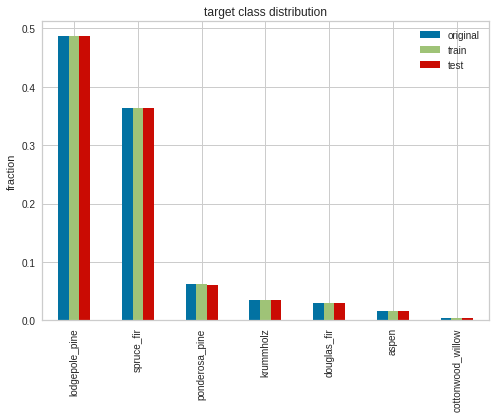

In [152]:
for_plot = ['target_name', 'original', 'train', 'test']
_ = df_target_dist[for_plot].set_index('target_name').plot.bar();
_ = plt.title('target class distribution');
_ = plt.xlabel('')
_ = plt.ylabel('fraction')

# `pycaret` `setup`
### `silent = True` to supress interactive confirmation of data types

In [153]:
#su_log_profile = True
su_log_profile = False

su_silent = True
#su_silent = False

#su_log_experiment = True
su_log_experiment = False

### variables to hold modeling results

In [154]:
df_pycaret_model_metrics = pd.DataFrame()
df_report_by_class = pd.DataFrame()
df_report_summary  = pd.DataFrame()

In [155]:
def grand_dataframe_creation(the_pycaret_models, the_df_data, train_indices, experiment_name, clear_data_frame=False):
    
    global df_pycaret_model_metrics, df_report_by_class, df_report_summary
    
    if (clear_data_frame):
        df_pycaret_model_metrics = pd.DataFrame()
        df_report_by_class = pd.DataFrame()
        df_report_summary  = pd.DataFrame()
    
    # get pycaret model grid results
    df_pull_temp = pull()
    df_pull_temp.reset_index(drop=True, inplace=True)
    df_pull_temp['soil encoding'] = experiment_name
    #print('df_pull_temp')
    #print(df_pull_temp)
    df_pycaret_model_metrics = df_pycaret_model_metrics.append(df_pull_temp, ignore_index=True)
    
    for imodel in range(len(the_pycaret_models)):
        # predict train data
        pred_train = predict_model(the_pycaret_models[imodel], data = the_df_data.loc[train_indices])
        #print('\npred_train')
        #print(pred_train.shape)
        #print(pred_train.head())

        # metrics by class
        pycaret_target_names = [1, 2, 3, 4, 5, 6, 7]

        df_by_class_temp, df_summary_temp = \
        make_dataframes_from_classification_report(df_pull_temp['Model'].values[imodel],
                                                   'train', pycaret_target_names,
                                                   pred_train['cover_type'], pred_train['Label'])
        df_by_class_temp['soil encoding'] = experiment_name
        df_summary_temp['soil encoding']  = experiment_name
        
        # add to master dataframes
        df_report_by_class  = df_report_by_class.append(df_by_class_temp, ignore_index=True)
        df_report_summary   = df_report_summary.append(df_summary_temp, ignore_index=True)
       
    return


# `pycaret` metrics and models
### models
- logistic regression
- decision tree
- XGBoost
- LightGBM (use categorical features directly)
- CatBoost (use categorical features directly)

In [156]:
def specify_metrics():
    get_metrics(reset=True)

    delete_metrics = ['auc', 'recall', 'kappa', 'mcc']
    for item in delete_metrics:
        remove_metric(item)

    _ = add_metric('re_wgt', 'Recall Weighted', recall_score, average='weighted')

    _ = add_metric('pr_macro', 'Precision Macro', precision_score, average='macro')
    _ = add_metric('re_macro', 'Recall Macro', recall_score, average='macro')
    _ = add_metric('f1_macro', 'F1 Macro', f1_score, average='macro')

In [157]:
models_to_run = ['lr', 'dt', 'xgboost', 'lightgbm', 'catboost']
#models_to_run = ['lr', 'dt']

# experiment 1
### min-max scale; 1-hot wild; 1-hot soil
### `setup`

In [158]:
su_experiment_name = 'one hot'
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='none')

features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
df_su = df_data_to_use[cols_to_use]

cols_to_use
features_cat
su_experiment_name

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'soil_index',
 'cover_type']

['wilderness_index', 'soil_index']

'one hot'

In [159]:
the_su     = setup(data = df_su, target = target_col[0],
                   categorical_features = features_cat,
                   normalize = True, normalize_method = 'minmax',
                   train_size = 0.7, fold = 3, session_id = 59,
                   log_experiment = su_log_experiment, experiment_name = su_experiment_name, log_profile = su_log_profile,
                   #profile = True
                   silent = su_silent
                   )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [160]:
dict_su_data = find_train_test_data_from_pycaret_setup(the_su,
                                        train_size=int(0.7*len(df_su)), test_size=int(0.3*len(df_su)))
dict_su_data

item= 11 type= <class 'pandas.core.series.Series'> (174304,)
item= 14 type= <class 'pandas.core.frame.DataFrame'> (406708, 54)
item= 19 type= <class 'pandas.core.series.Series'> (581012,)
item= 22 type= <class 'pandas.core.series.Series'> (406708,)
item= 23 type= <class 'pandas.core.frame.DataFrame'> (581012, 13)
item= 25 type= <class 'pandas.core.frame.DataFrame'> (174304, 54)
item= 40 type= <class 'pandas.core.frame.DataFrame'> (581012, 54)


{'X_train': 14, 'y_train': 22, 'X_test': 25, 'y_test': 11}

In [161]:
su_train_indices = the_su[dict_su_data['X_train']].index
su_test_indices  = the_su[dict_su_data['X_test']].index
su_train_indices

Int64Index([386294,  93226,   1249, 298742, 469966, 397767,  91286, 324927,
            245109, 411449,
            ...
            528664, 468432, 128653, 222831, 550590, 528447,  23996, 127908,
            543892, 431852],
           dtype='int64', length=406708)

In [162]:
df_su.loc[su_train_indices]

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,wilderness_index,soil_index,cover_type
386294,2954,19,17,552,159,3094,206,203,130,886,2,10,2
93226,2926,295,11,306,17,5651,190,237,187,3361,0,23,2
1249,3178,263,9,272,58,5807,197,245,187,2941,0,22,2
298742,2971,132,15,90,9,888,242,232,115,175,2,32,2
469966,3294,1,12,446,98,2758,203,217,152,2325,2,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528447,3070,250,19,335,44,3443,177,250,209,1549,2,13,1
23996,2860,45,7,402,88,3548,222,224,137,6032,0,12,1
127908,3011,90,7,150,14,4279,231,229,130,684,0,29,2
543892,3216,1,17,366,69,4152,194,206,148,930,2,24,1


### `compare_models`

In [163]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f1948362820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7f194836d550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7f194836d040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [164]:
models_one_hot = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133
catboost,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500
xgboost,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433
lightgbm,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633
lr,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367


In [165]:
models_one_hot

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=59, splitter='best'),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
               objective='multi:softprob', random_state=59, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=None, subsample=1,
     

### make all dataframes

In [166]:
grand_dataframe_creation(models_one_hot, df_su, su_train_indices, su_experiment_name)

In [167]:
df_pycaret_model_metrics

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec),soil encoding
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot


In [168]:
df_report_by_class

,model,data,class,precision,recall,f1-score,support,soil encoding
0,Decision Tree Classifier,train,1,0.845089,0.853527,0.849287,148628,one hot
1,Decision Tree Classifier,train,2,0.857727,0.890423,0.873769,197906,one hot
2,Decision Tree Classifier,train,3,0.796507,0.550412,0.650978,25103,one hot
3,Decision Tree Classifier,train,4,0.562500,0.524454,0.542811,1922,one hot
4,Decision Tree Classifier,train,5,0.768873,0.594449,0.670503,6665,one hot
5,Decision Tree Classifier,train,6,0.543766,0.656662,0.594906,12128,one hot
6,Decision Tree Classifier,train,7,0.785796,0.668222,0.722256,14356,one hot
7,CatBoost Classifier,train,1,0.815850,0.794393,0.804978,148628,one hot
8,CatBoost Classifier,train,2,0.814997,0.871156,0.842142,197906,one hot
9,CatBoost Classifier,train,3,0.908482,0.713779,0.799447,25103,one hot


In [169]:
df_report_summary

,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score,soil encoding
0,Decision Tree Classifier,train,0.834559,0.737180,0.676878,0.700644,0.834577,0.834559,0.832512,one hot
1,CatBoost Classifier,train,0.817024,0.835043,0.705573,0.742205,0.820341,0.817024,0.814359,one hot
2,Extreme Gradient Boosting,train,0.808145,0.861236,0.697845,0.748429,0.811504,0.808145,0.805054,one hot
3,Light Gradient Boosting Machine,train,0.781716,0.782765,0.602877,0.644697,0.783425,0.781716,0.775271,one hot
4,Logistic Regression,train,0.679040,0.520124,0.424880,0.404729,0.688955,0.679040,0.659003,one hot


### investigate results

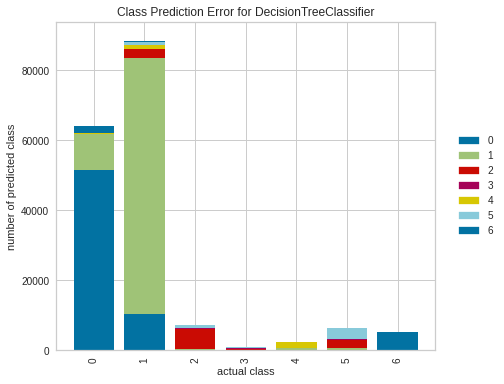

In [170]:
plot_model(models_one_hot[0], plot='error')

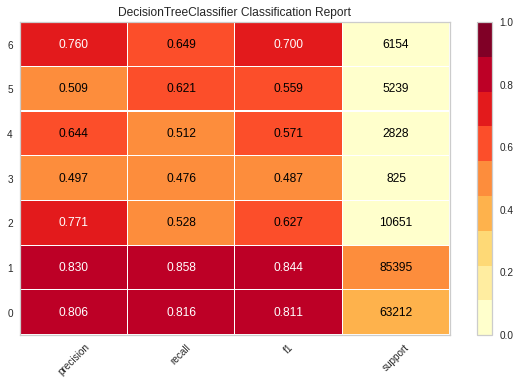

In [171]:
plot_model(models_one_hot[0], plot='class_report')

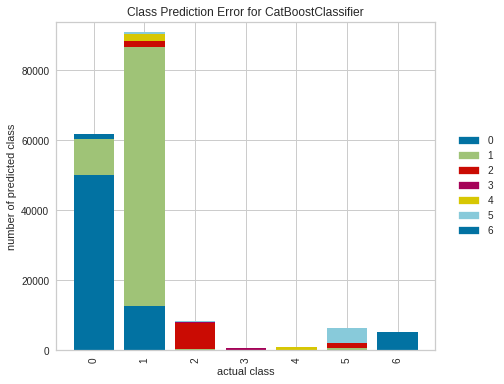

In [172]:
plot_model(models_one_hot[1], plot='error')

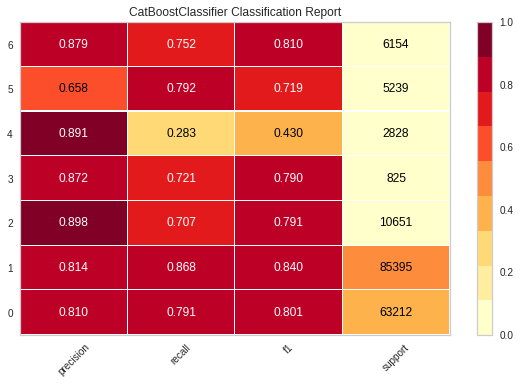

In [173]:
plot_model(models_one_hot[1], plot='class_report')

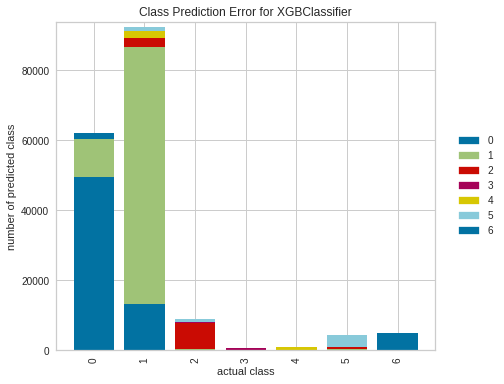

In [174]:
plot_model(models_one_hot[2], plot='error')

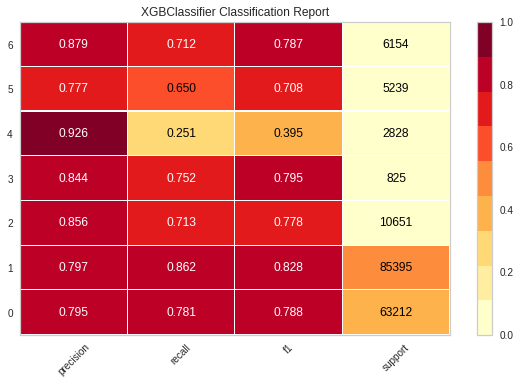

In [175]:
plot_model(models_one_hot[2], plot='class_report')

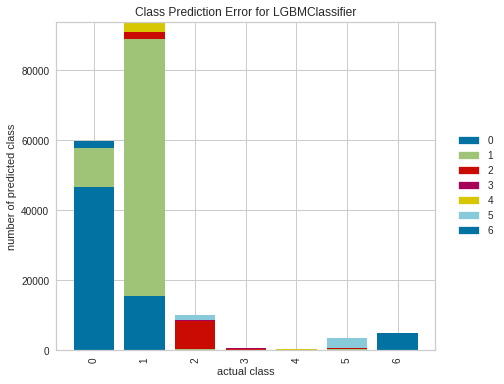

In [176]:
plot_model(models_one_hot[3], plot='error')

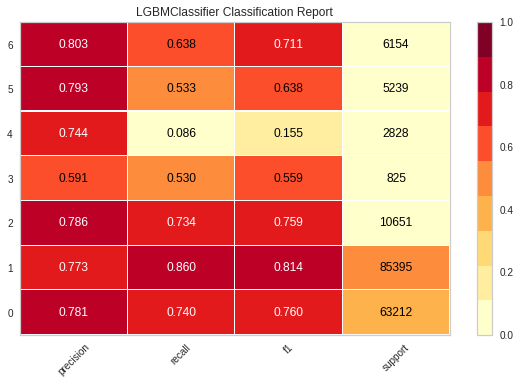

In [177]:
plot_model(models_one_hot[3], plot='class_report')

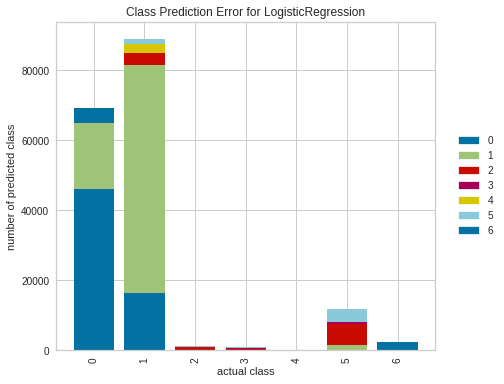

In [178]:
plot_model(models_one_hot[4], plot='error')

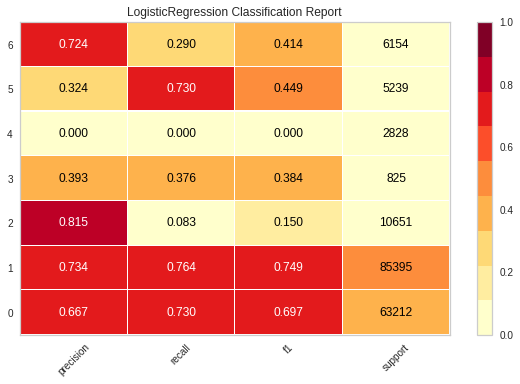

In [179]:
plot_model(models_one_hot[4], plot='class_report')

# experiment 2
### min-max scale; 1-hot wild; frequency soil

In [180]:
su_experiment_name = 'frequency'
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='none')

features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
df_su = df_data_to_use[cols_to_use]

cols_to_use
features_cat
su_experiment_name

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'soil_index',
 'cover_type']

['wilderness_index', 'soil_index']

'frequency'

In [181]:
the_su       = setup(data = df_su, target = target_col[0],
                     categorical_features = features_cat,
                     normalize = True, normalize_method = 'minmax',
                     high_cardinality_features = ['soil_index'], high_cardinality_method = 'frequency',
                     train_size = 0.7, fold = 3, session_id = 59,
                     log_experiment = su_log_experiment, experiment_name = su_experiment_name, log_profile = su_log_profile,
                     #profile = True
                     silent = su_silent
                     )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,True


In [182]:
dict_su_data = find_train_test_data_from_pycaret_setup(the_su,
                                        train_size=int(0.7*len(df_su)), test_size=int(0.3*len(df_su)))
dict_su_data

item= 11 type= <class 'pandas.core.series.Series'> (174304,)
item= 14 type= <class 'pandas.core.frame.DataFrame'> (406708, 15)
item= 19 type= <class 'pandas.core.series.Series'> (581012,)
item= 22 type= <class 'pandas.core.series.Series'> (406708,)
item= 23 type= <class 'pandas.core.frame.DataFrame'> (581012, 13)
item= 25 type= <class 'pandas.core.frame.DataFrame'> (174304, 15)
item= 40 type= <class 'pandas.core.frame.DataFrame'> (581012, 15)


{'X_train': 14, 'y_train': 22, 'X_test': 25, 'y_test': 11}

In [183]:
su_train_indices = the_su[dict_su_data['X_train']].index
su_test_indices  = the_su[dict_su_data['X_test']].index
su_train_indices

Int64Index([386294,  93226,   1249, 298742, 469966, 397767,  91286, 324927,
            245109, 411449,
            ...
            528664, 468432, 128653, 222831, 550590, 528447,  23996, 127908,
            543892, 431852],
           dtype='int64', length=406708)

### `compare_models`

In [184]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f1948362820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7f194836d550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7f194836d040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [185]:
models_freq = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9181,0.9181,0.9181,0.9181,0.8711,0.8673,0.8692,1.6600
catboost,CatBoost Classifier,0.8820,0.8820,0.8811,0.8820,0.8790,0.8150,0.8416,78.4167
xgboost,Extreme Gradient Boosting,0.8778,0.8779,0.8771,0.8778,0.8883,0.8310,0.8550,118.5633
lightgbm,Light Gradient Boosting Machine,0.8542,0.8540,0.8536,0.8542,0.8466,0.8091,0.8254,7.6167
lr,Logistic Regression,0.7084,0.6919,0.6954,0.7084,0.5654,0.4325,0.4604,50.2333


### make all dataframes

In [186]:
grand_dataframe_creation(models_freq, df_su, su_train_indices, su_experiment_name)

In [187]:
df_pycaret_model_metrics

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec),soil encoding
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot
5,Decision Tree Classifier,0.9181,0.9181,0.9181,0.9181,0.8711,0.8673,0.8692,1.6600,frequency
6,CatBoost Classifier,0.8820,0.8820,0.8811,0.8820,0.8790,0.8150,0.8416,78.4167,frequency
7,Extreme Gradient Boosting,0.8778,0.8779,0.8771,0.8778,0.8883,0.8310,0.8550,118.5633,frequency
8,Light Gradient Boosting Machine,0.8542,0.8540,0.8536,0.8542,0.8466,0.8091,0.8254,7.6167,frequency
9,Logistic Regression,0.7084,0.6919,0.6954,0.7084,0.5654,0.4325,0.4604,50.2333,frequency


In [188]:
df_report_by_class

,model,data,class,precision,recall,f1-score,support,soil encoding
0,Decision Tree Classifier,train,1,0.845089,0.853527,0.849287,148628,one hot
1,Decision Tree Classifier,train,2,0.857727,0.890423,0.873769,197906,one hot
2,Decision Tree Classifier,train,3,0.796507,0.550412,0.650978,25103,one hot
3,Decision Tree Classifier,train,4,0.562500,0.524454,0.542811,1922,one hot
4,Decision Tree Classifier,train,5,0.768873,0.594449,0.670503,6665,one hot
...,...,...,...,...,...,...,...,...
65,Logistic Regression,train,3,0.590819,0.866470,0.702574,25103,frequency
66,Logistic Regression,train,4,0.624599,0.303850,0.408820,1922,frequency
67,Logistic Regression,train,5,0.000000,0.000000,0.000000,6665,frequency
68,Logistic Regression,train,6,0.467922,0.065551,0.114992,12128,frequency


In [189]:
df_report_summary

,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score,soil encoding
0,Decision Tree Classifier,train,0.834559,0.737180,0.676878,0.700644,0.834577,0.834559,0.832512,one hot
1,CatBoost Classifier,train,0.817024,0.835043,0.705573,0.742205,0.820341,0.817024,0.814359,one hot
2,Extreme Gradient Boosting,train,0.808145,0.861236,0.697845,0.748429,0.811504,0.808145,0.805054,one hot
3,Light Gradient Boosting Machine,train,0.781716,0.782765,0.602877,0.644697,0.783425,0.781716,0.775271,one hot
4,Logistic Regression,train,0.679040,0.520124,0.424880,0.404729,0.688955,0.679040,0.659003,one hot
5,Decision Tree Classifier,train,0.591847,0.440894,0.469238,0.428013,0.632840,0.591847,0.599689,frequency
6,CatBoost Classifier,train,0.720900,0.754692,0.625797,0.615435,0.755243,0.720900,0.714539,frequency
7,Extreme Gradient Boosting,train,0.753504,0.783948,0.616751,0.625485,0.762202,0.753504,0.746039,frequency
8,Light Gradient Boosting Machine,train,0.728550,0.671213,0.667900,0.644337,0.747223,0.728550,0.728038,frequency
9,Logistic Regression,train,0.696060,0.518736,0.468438,0.459588,0.685865,0.696060,0.683425,frequency


### investigate results

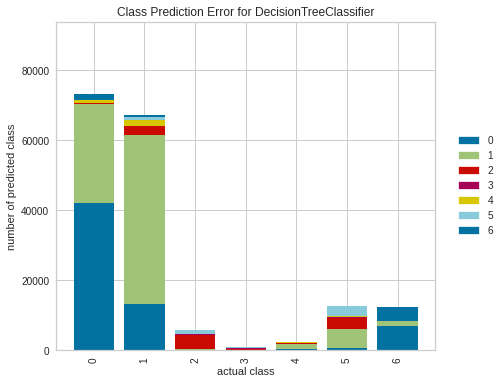

In [190]:
plot_model(models_freq[0], plot='error')

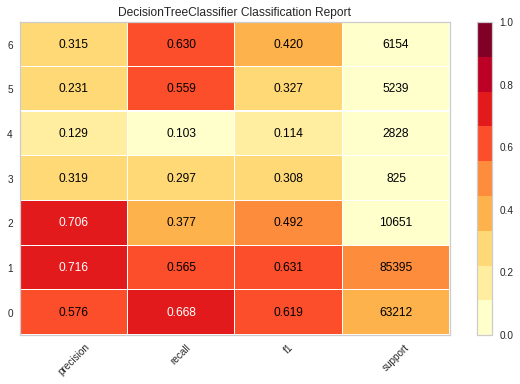

In [191]:
plot_model(models_freq[0], plot='class_report')

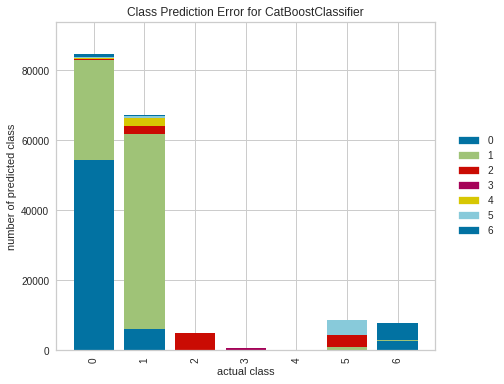

In [192]:
plot_model(models_freq[1], plot='error')

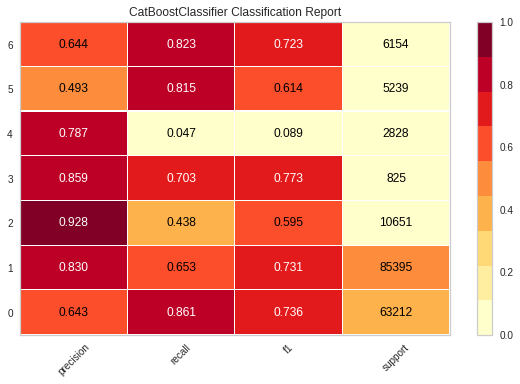

In [193]:
plot_model(models_freq[1], plot='class_report')

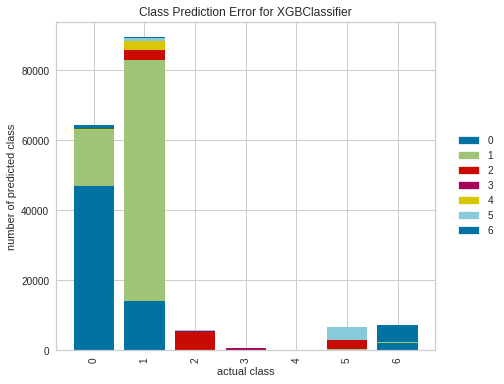

In [194]:
plot_model(models_freq[2], plot='error')

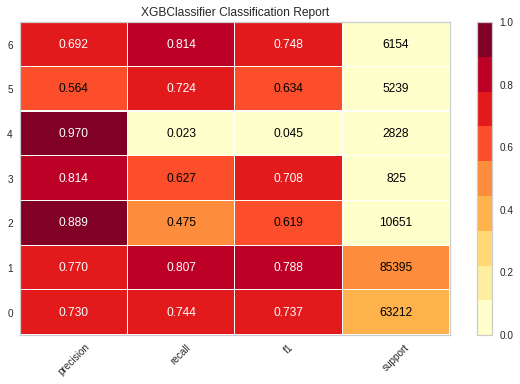

In [195]:
plot_model(models_freq[2], plot='class_report')

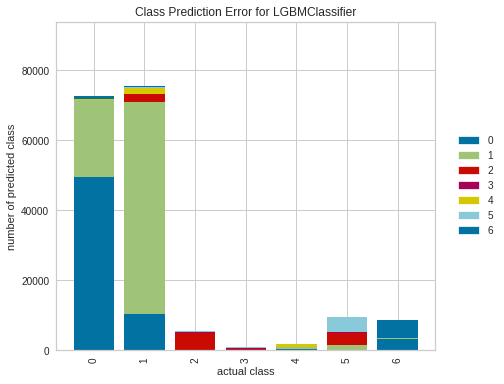

In [196]:
plot_model(models_freq[3], plot='error')

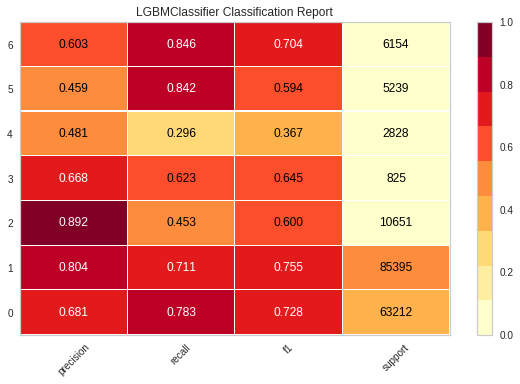

In [197]:
plot_model(models_freq[3], plot='class_report')

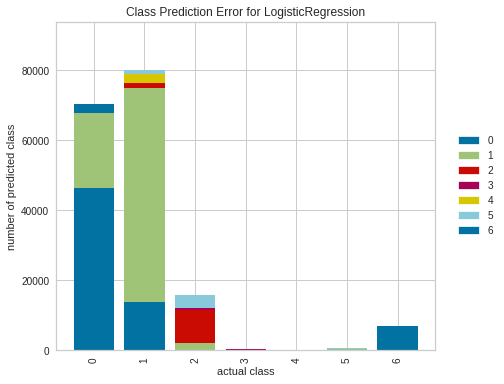

In [198]:
plot_model(models_freq[4], plot='error')

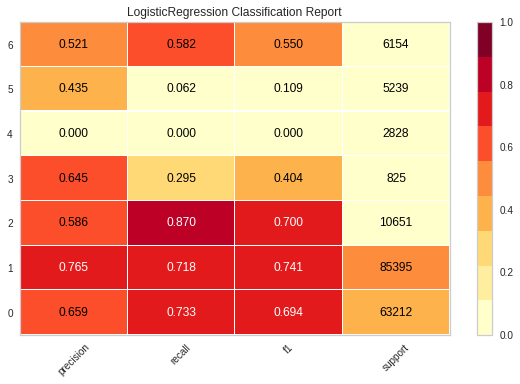

In [199]:
plot_model(models_freq[4], plot='class_report')

# experiment 3
### min-max scale; 1-hot wild; climatic soil

In [200]:
su_experiment_name = 'climatic clusters'
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='climatic')

features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
df_su = df_data_to_use[cols_to_use]

cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'climatic_zone',
 'cover_type']

['wilderness_index', 'climatic_zone']

In [201]:
the_su           = setup(data = df_su, target = target_col[0],
                         categorical_features = features_cat,
                         normalize = True, normalize_method = 'minmax',
                         train_size = 0.7, fold = 3, session_id = 59,
                         log_experiment = su_log_experiment, experiment_name = su_experiment_name, log_profile = su_log_profile,
                         #profile = True
                         silent = su_silent
                         )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [202]:
dict_su_data = find_train_test_data_from_pycaret_setup(the_su,
                                        train_size=int(0.7*len(df_su)), test_size=int(0.3*len(df_su)))
dict_su_data

item= 11 type= <class 'pandas.core.series.Series'> (174304,)
item= 14 type= <class 'pandas.core.frame.DataFrame'> (406708, 21)
item= 19 type= <class 'pandas.core.series.Series'> (581012,)
item= 22 type= <class 'pandas.core.series.Series'> (406708,)
item= 23 type= <class 'pandas.core.frame.DataFrame'> (581012, 13)
item= 25 type= <class 'pandas.core.frame.DataFrame'> (174304, 21)
item= 40 type= <class 'pandas.core.frame.DataFrame'> (581012, 21)


{'X_train': 14, 'y_train': 22, 'X_test': 25, 'y_test': 11}

In [203]:
su_train_indices = the_su[dict_su_data['X_train']].index
su_test_indices  = the_su[dict_su_data['X_test']].index
su_train_indices

Int64Index([386294,  93226,   1249, 298742, 469966, 397767,  91286, 324927,
            245109, 411449,
            ...
            528664, 468432, 128653, 222831, 550590, 528447,  23996, 127908,
            543892, 431852],
           dtype='int64', length=406708)

### `compare_models`

In [204]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f1948362820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7f194836d550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7f194836d040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [205]:
models_climatic = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9102,0.9102,0.9102,0.9102,0.8582,0.8570,0.8575,1.6267
catboost,CatBoost Classifier,0.8704,0.8704,0.8694,0.8704,0.8726,0.8019,0.8307,87.7467
xgboost,Extreme Gradient Boosting,0.8582,0.8584,0.8575,0.8582,0.8761,0.8144,0.8396,120.8633
lightgbm,Light Gradient Boosting Machine,0.8429,0.8427,0.8423,0.8429,0.8345,0.7945,0.8111,6.9233
lr,Logistic Regression,0.7150,0.6987,0.7030,0.7150,0.5654,0.4642,0.4852,55.8467


### make all dataframes

In [206]:
grand_dataframe_creation(models_climatic, df_su, su_train_indices, su_experiment_name)

In [207]:
df_pycaret_model_metrics

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec),soil encoding
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot
5,Decision Tree Classifier,0.9181,0.9181,0.9181,0.9181,0.8711,0.8673,0.8692,1.6600,frequency
6,CatBoost Classifier,0.8820,0.8820,0.8811,0.8820,0.8790,0.8150,0.8416,78.4167,frequency
7,Extreme Gradient Boosting,0.8778,0.8779,0.8771,0.8778,0.8883,0.8310,0.8550,118.5633,frequency
8,Light Gradient Boosting Machine,0.8542,0.8540,0.8536,0.8542,0.8466,0.8091,0.8254,7.6167,frequency
9,Logistic Regression,0.7084,0.6919,0.6954,0.7084,0.5654,0.4325,0.4604,50.2333,frequency


In [208]:
df_report_by_class

,model,data,class,precision,recall,f1-score,support,soil encoding
0,Decision Tree Classifier,train,1,0.845089,0.853527,0.849287,148628,one hot
1,Decision Tree Classifier,train,2,0.857727,0.890423,0.873769,197906,one hot
2,Decision Tree Classifier,train,3,0.796507,0.550412,0.650978,25103,one hot
3,Decision Tree Classifier,train,4,0.562500,0.524454,0.542811,1922,one hot
4,Decision Tree Classifier,train,5,0.768873,0.594449,0.670503,6665,one hot
...,...,...,...,...,...,...,...,...
100,Logistic Regression,train,3,0.659952,0.823527,0.732721,25103,climatic clusters
101,Logistic Regression,train,4,0.705109,0.251301,0.370541,1922,climatic clusters
102,Logistic Regression,train,5,0.000000,0.000000,0.000000,6665,climatic clusters
103,Logistic Regression,train,6,0.464789,0.182305,0.261889,12128,climatic clusters


In [209]:
df_report_summary

,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score,soil encoding
0,Decision Tree Classifier,train,0.834559,0.737180,0.676878,0.700644,0.834577,0.834559,0.832512,one hot
1,CatBoost Classifier,train,0.817024,0.835043,0.705573,0.742205,0.820341,0.817024,0.814359,one hot
2,Extreme Gradient Boosting,train,0.808145,0.861236,0.697845,0.748429,0.811504,0.808145,0.805054,one hot
3,Light Gradient Boosting Machine,train,0.781716,0.782765,0.602877,0.644697,0.783425,0.781716,0.775271,one hot
4,Logistic Regression,train,0.679040,0.520124,0.424880,0.404729,0.688955,0.679040,0.659003,one hot
5,Decision Tree Classifier,train,0.591847,0.440894,0.469238,0.428013,0.632840,0.591847,0.599689,frequency
6,CatBoost Classifier,train,0.720900,0.754692,0.625797,0.615435,0.755243,0.720900,0.714539,frequency
7,Extreme Gradient Boosting,train,0.753504,0.783948,0.616751,0.625485,0.762202,0.753504,0.746039,frequency
8,Light Gradient Boosting Machine,train,0.728550,0.671213,0.667900,0.644337,0.747223,0.728550,0.728038,frequency
9,Logistic Regression,train,0.696060,0.518736,0.468438,0.459588,0.685865,0.696060,0.683425,frequency


### investigate results

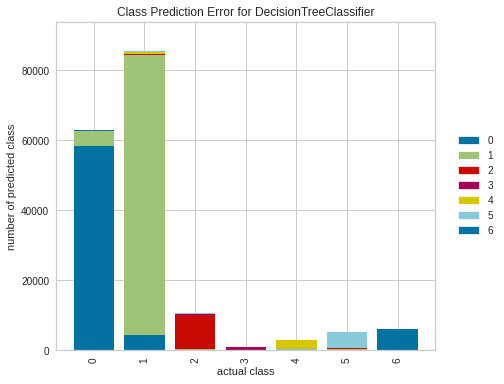

In [210]:
plot_model(models_climatic[0], plot='error')

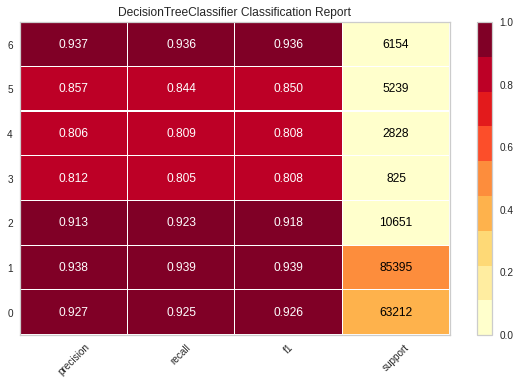

In [211]:
plot_model(models_climatic[0], plot='class_report')

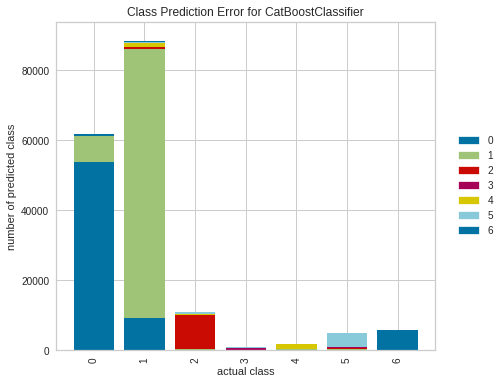

In [212]:
plot_model(models_climatic[1], plot='error')

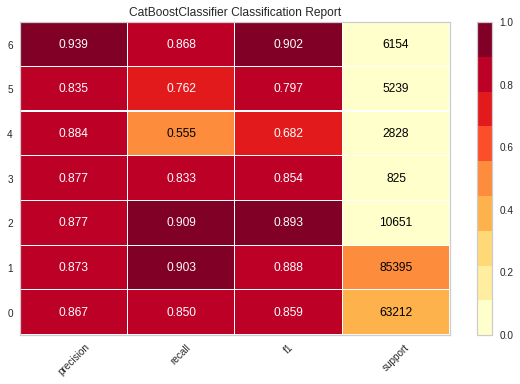

In [213]:
plot_model(models_climatic[1], plot='class_report')

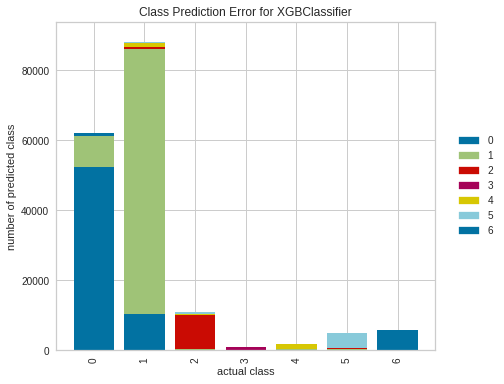

In [214]:
plot_model(models_climatic[2], plot='error')

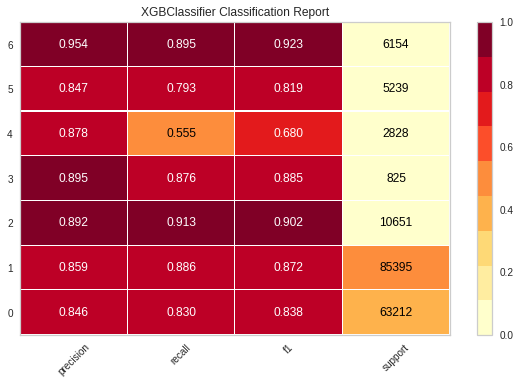

In [215]:
plot_model(models_climatic[2], plot='class_report')

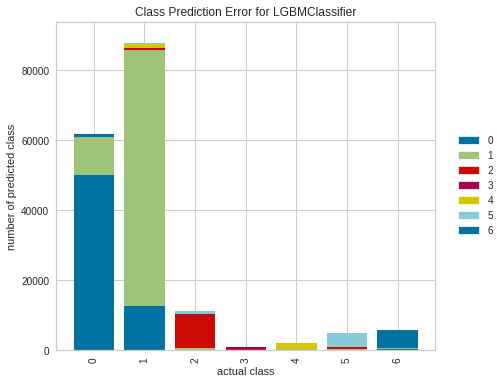

In [216]:
plot_model(models_climatic[3], plot='error')

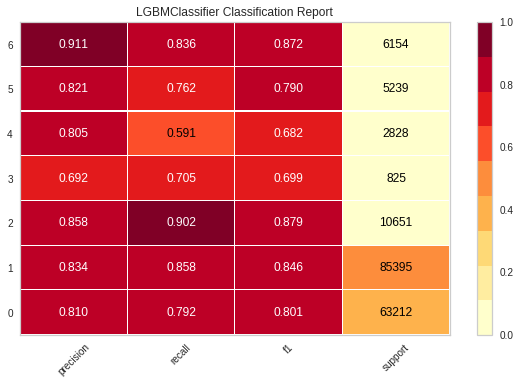

In [217]:
plot_model(models_climatic[3], plot='class_report')

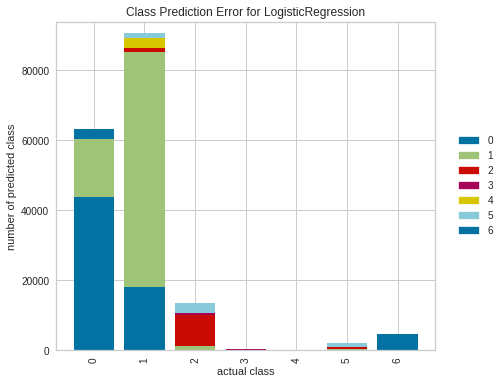

In [218]:
plot_model(models_climatic[4], plot='error')

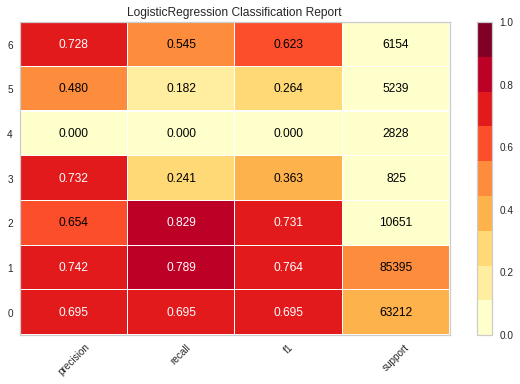

In [219]:
plot_model(models_climatic[4], plot='class_report')

# experiment 4
### min-max scale; 1-hot wild; geologic soil

In [220]:
su_experiment_name = 'geologic clusters'
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='geologic')

features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
df_su = df_data_to_use[cols_to_use]

cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'geologic_zone',
 'cover_type']

['wilderness_index', 'geologic_zone']

In [221]:
the_su           = setup(data = df_su, target = target_col[0],
                         categorical_features = features_cat,
                         normalize = True, normalize_method = 'minmax',
                         train_size = 0.7, fold = 3, session_id = 59,
                         log_experiment = su_log_experiment, experiment_name = su_experiment_name, log_profile = su_log_profile,
                         #profile = True
                         silent = su_silent
                         )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [222]:
dict_su_data = find_train_test_data_from_pycaret_setup(the_su,
                                        train_size=int(0.7*len(df_su)), test_size=int(0.3*len(df_su)))
dict_su_data

item= 11 type= <class 'pandas.core.series.Series'> (174304,)
item= 14 type= <class 'pandas.core.frame.DataFrame'> (406708, 18)
item= 19 type= <class 'pandas.core.series.Series'> (581012,)
item= 22 type= <class 'pandas.core.series.Series'> (406708,)
item= 23 type= <class 'pandas.core.frame.DataFrame'> (581012, 13)
item= 25 type= <class 'pandas.core.frame.DataFrame'> (174304, 18)
item= 40 type= <class 'pandas.core.frame.DataFrame'> (581012, 18)


{'X_train': 14, 'y_train': 22, 'X_test': 25, 'y_test': 11}

In [223]:
su_train_indices = the_su[dict_su_data['X_train']].index
su_test_indices  = the_su[dict_su_data['X_test']].index
su_train_indices

Int64Index([386294,  93226,   1249, 298742, 469966, 397767,  91286, 324927,
            245109, 411449,
            ...
            528664, 468432, 128653, 222831, 550590, 528447,  23996, 127908,
            543892, 431852],
           dtype='int64', length=406708)

### `compare_models`

In [224]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f1948362820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7f194836d550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7f194836d040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [225]:
models_geologic = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9092,0.9091,0.9091,0.9092,0.8556,0.8525,0.8539,1.6733
catboost,CatBoost Classifier,0.8702,0.8703,0.8691,0.8702,0.8702,0.7947,0.8254,78.4600
xgboost,Extreme Gradient Boosting,0.8600,0.8603,0.8591,0.8600,0.8738,0.8044,0.8323,117.3000
lightgbm,Light Gradient Boosting Machine,0.8410,0.8410,0.8403,0.8410,0.8323,0.7805,0.8021,7.3533
lr,Logistic Regression,0.7089,0.6912,0.6951,0.7089,0.5474,0.4252,0.4518,54.2267


### make all dataframes

In [226]:
grand_dataframe_creation(models_geologic, df_su, su_train_indices, su_experiment_name)

In [227]:
df_pycaret_model_metrics

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec),soil encoding
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot
5,Decision Tree Classifier,0.9181,0.9181,0.9181,0.9181,0.8711,0.8673,0.8692,1.6600,frequency
6,CatBoost Classifier,0.8820,0.8820,0.8811,0.8820,0.8790,0.8150,0.8416,78.4167,frequency
7,Extreme Gradient Boosting,0.8778,0.8779,0.8771,0.8778,0.8883,0.8310,0.8550,118.5633,frequency
8,Light Gradient Boosting Machine,0.8542,0.8540,0.8536,0.8542,0.8466,0.8091,0.8254,7.6167,frequency
9,Logistic Regression,0.7084,0.6919,0.6954,0.7084,0.5654,0.4325,0.4604,50.2333,frequency


In [228]:
df_report_by_class

,model,data,class,precision,recall,f1-score,support,soil encoding
0,Decision Tree Classifier,train,1,0.845089,0.853527,0.849287,148628,one hot
1,Decision Tree Classifier,train,2,0.857727,0.890423,0.873769,197906,one hot
2,Decision Tree Classifier,train,3,0.796507,0.550412,0.650978,25103,one hot
3,Decision Tree Classifier,train,4,0.562500,0.524454,0.542811,1922,one hot
4,Decision Tree Classifier,train,5,0.768873,0.594449,0.670503,6665,one hot
...,...,...,...,...,...,...,...,...
135,Logistic Regression,train,3,0.636068,0.763494,0.693980,25103,geologic clusters
136,Logistic Regression,train,4,0.696203,0.228928,0.344558,1922,geologic clusters
137,Logistic Regression,train,5,0.000000,0.000000,0.000000,6665,geologic clusters
138,Logistic Regression,train,6,0.418679,0.161527,0.233117,12128,geologic clusters


In [229]:
df_report_summary

,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score,soil encoding
0,Decision Tree Classifier,train,0.834559,0.737180,0.676878,0.700644,0.834577,0.834559,0.832512,one hot
1,CatBoost Classifier,train,0.817024,0.835043,0.705573,0.742205,0.820341,0.817024,0.814359,one hot
2,Extreme Gradient Boosting,train,0.808145,0.861236,0.697845,0.748429,0.811504,0.808145,0.805054,one hot
3,Light Gradient Boosting Machine,train,0.781716,0.782765,0.602877,0.644697,0.783425,0.781716,0.775271,one hot
4,Logistic Regression,train,0.679040,0.520124,0.424880,0.404729,0.688955,0.679040,0.659003,one hot
5,Decision Tree Classifier,train,0.591847,0.440894,0.469238,0.428013,0.632840,0.591847,0.599689,frequency
6,CatBoost Classifier,train,0.720900,0.754692,0.625797,0.615435,0.755243,0.720900,0.714539,frequency
7,Extreme Gradient Boosting,train,0.753504,0.783948,0.616751,0.625485,0.762202,0.753504,0.746039,frequency
8,Light Gradient Boosting Machine,train,0.728550,0.671213,0.667900,0.644337,0.747223,0.728550,0.728038,frequency
9,Logistic Regression,train,0.696060,0.518736,0.468438,0.459588,0.685865,0.696060,0.683425,frequency


### investigate results

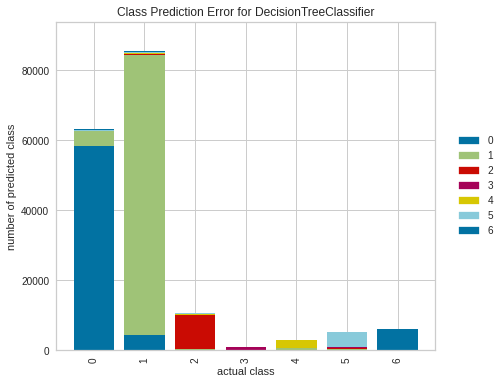

In [230]:
plot_model(models_geologic[0], plot='error')

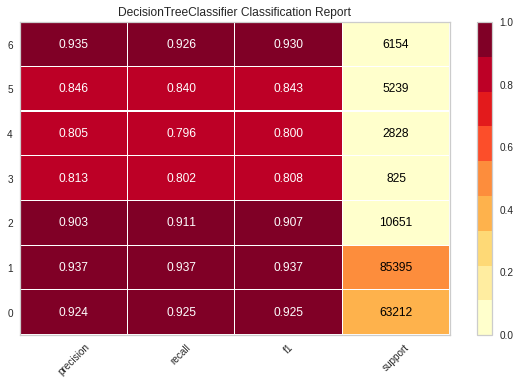

In [231]:
plot_model(models_geologic[0], plot='class_report')

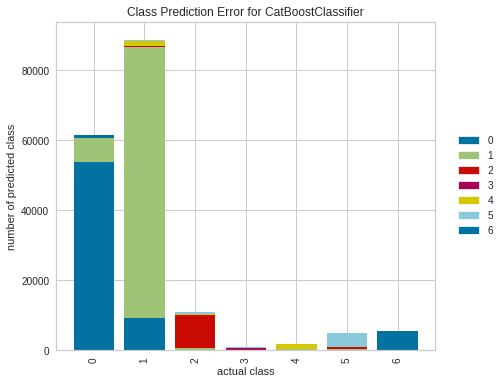

In [232]:
plot_model(models_geologic[1], plot='error')

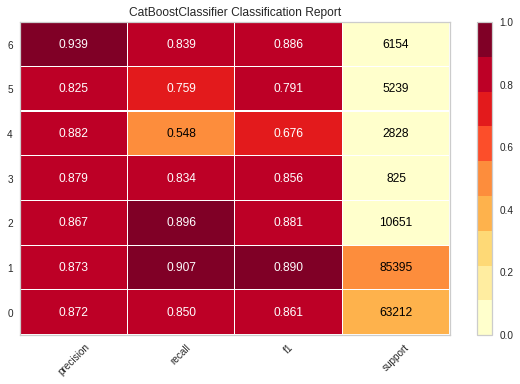

In [233]:
plot_model(models_geologic[1], plot='class_report')

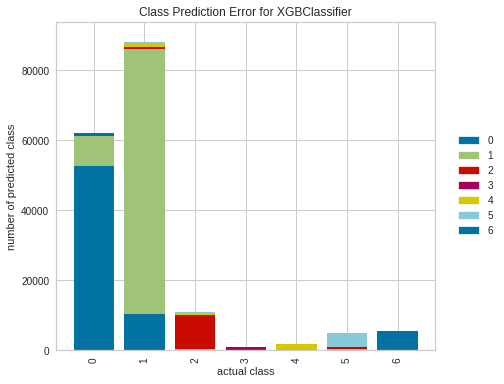

In [234]:
plot_model(models_geologic[2], plot='error')

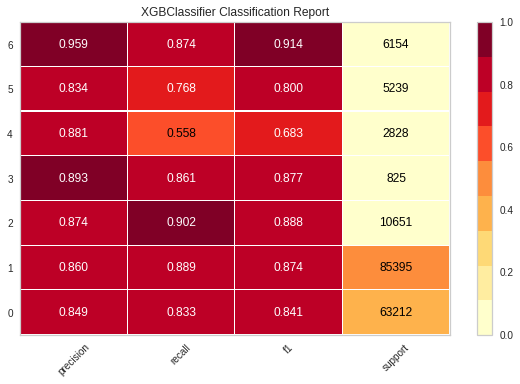

In [235]:
plot_model(models_geologic[2], plot='class_report')

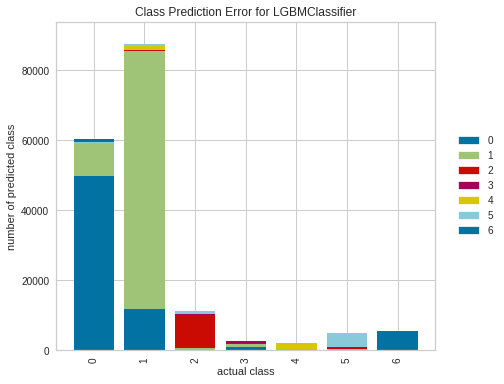

In [236]:
plot_model(models_geologic[3], plot='error')

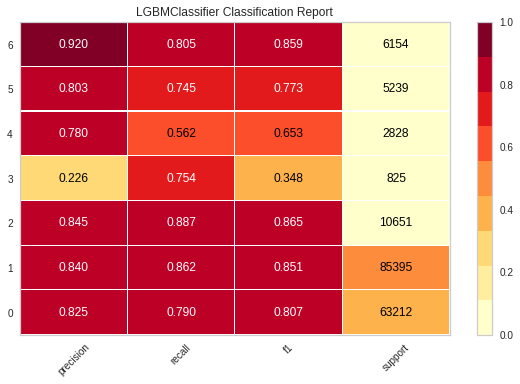

In [237]:
plot_model(models_geologic[3], plot='class_report')

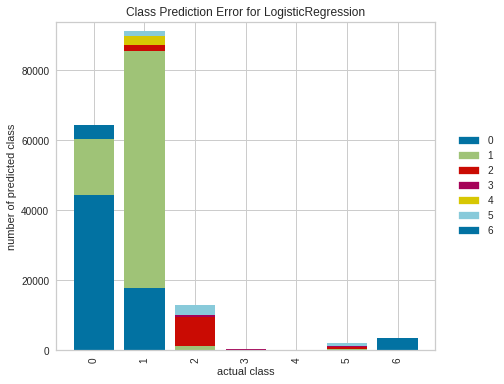

In [238]:
plot_model(models_geologic[4], plot='error')

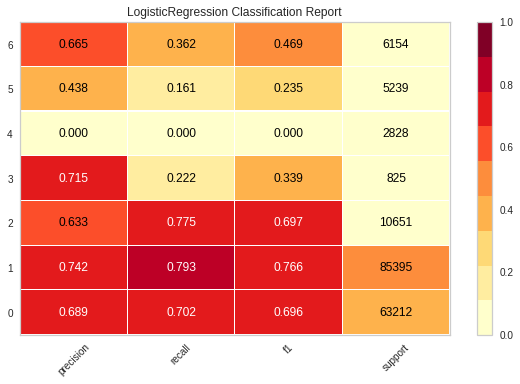

In [239]:
plot_model(models_geologic[4], plot='class_report')

# experiment 5
### min-max scale; 1-hot wild; both soil

In [240]:
su_experiment_name = 'both clusters'
features_to_use = make_feature_columns_list(numerical_scaled=False, wild_area_one_hot=False,
                                            soil_type_one_hot=False, soil_type_cluster='both')

features_cat = features_to_use[-2:]
cols_to_use = features_to_use + target_col
df_su = df_data_to_use[cols_to_use]

cols_to_use
features_cat

['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points',
 'wilderness_index',
 'both_zones',
 'cover_type']

['wilderness_index', 'both_zones']

In [241]:
the_su       = setup(data = df_su, target = target_col[0],
                     categorical_features = features_cat,
                     normalize = True, normalize_method = 'minmax',
                     train_size = 0.7, fold = 3, session_id = 59,
                     log_experiment = su_log_experiment, experiment_name = su_experiment_name, log_profile = su_log_profile,
                     #profile = True
                     silent = su_silent
                     )

,Description,Value
0,session_id,59
1,Target,cover_type
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6"
4,Original Data,"(581012, 13)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [242]:
dict_su_data = find_train_test_data_from_pycaret_setup(the_su,
                                        train_size=int(0.7*len(df_su)), test_size=int(0.3*len(df_su)))
dict_su_data

item= 11 type= <class 'pandas.core.series.Series'> (174304,)
item= 14 type= <class 'pandas.core.frame.DataFrame'> (406708, 25)
item= 19 type= <class 'pandas.core.series.Series'> (581012,)
item= 22 type= <class 'pandas.core.series.Series'> (406708,)
item= 23 type= <class 'pandas.core.frame.DataFrame'> (581012, 13)
item= 25 type= <class 'pandas.core.frame.DataFrame'> (174304, 25)
item= 40 type= <class 'pandas.core.frame.DataFrame'> (581012, 25)


{'X_train': 14, 'y_train': 22, 'X_test': 25, 'y_test': 11}

In [243]:
su_train_indices = the_su[dict_su_data['X_train']].index
su_test_indices  = the_su[dict_su_data['X_test']].index
su_train_indices

Int64Index([386294,  93226,   1249, 298742, 469966, 397767,  91286, 324927,
            245109, 411449,
            ...
            528664, 468432, 128653, 222831, 550590, 528447,  23996, 127908,
            543892, 431852],
           dtype='int64', length=406708)

### `compare_models`

In [244]:
specify_metrics()
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f1948362820>,accuracy,pred,{},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
re_wgt,Recall Weighted,Recall Weighted,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,True
pr_macro,Precision Macro,Precision Macro,<function precision_score at 0x7f194836d550>,"make_scorer(precision_score, average=macro)",pred,{'average': 'macro'},True,True,True
re_macro,Recall Macro,Recall Macro,<function recall_score at 0x7f194836d670>,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,True
f1_macro,F1 Macro,F1 Macro,<function f1_score at 0x7f194836d040>,"make_scorer(f1_score, average=macro)",pred,{'average': 'macro'},True,True,True


In [245]:
models_both = compare_models(include=models_to_run, sort='Accuracy', n_select=len(models_to_run))

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec)
dt,Decision Tree Classifier,0.9127,0.9127,0.9127,0.9127,0.8624,0.8602,0.8613,1.7033
catboost,CatBoost Classifier,0.8737,0.8737,0.8728,0.8737,0.8724,0.8050,0.8329,77.5267
xgboost,Extreme Gradient Boosting,0.8632,0.8633,0.8624,0.8632,0.8784,0.8176,0.8424,124.7133
lightgbm,Light Gradient Boosting Machine,0.8465,0.8466,0.8459,0.8465,0.8337,0.7982,0.8122,6.8333
lr,Logistic Regression,0.7188,0.7024,0.7066,0.7188,0.5680,0.4656,0.4871,57.1967


### make all dataframes

In [246]:
grand_dataframe_creation(models_both, df_su, su_train_indices, su_experiment_name)

In [247]:
df_pycaret_model_metrics

,Model,Accuracy,Prec.,F1,Recall Weighted,Precision Macro,Recall Macro,F1 Macro,TT (Sec),soil encoding
0,Decision Tree Classifier,0.9211,0.9211,0.9211,0.9211,0.8770,0.8733,0.8751,2.0133,one hot
1,CatBoost Classifier,0.8810,0.8810,0.8802,0.8810,0.8777,0.8163,0.8422,75.9500,one hot
2,Extreme Gradient Boosting,0.8692,0.8693,0.8685,0.8692,0.8826,0.8248,0.8484,155.3433,one hot
3,Light Gradient Boosting Machine,0.8554,0.8554,0.8548,0.8554,0.8529,0.8097,0.8284,7.1633,one hot
4,Logistic Regression,0.7242,0.7114,0.7135,0.7242,0.5899,0.5007,0.5205,69.8367,one hot
5,Decision Tree Classifier,0.9181,0.9181,0.9181,0.9181,0.8711,0.8673,0.8692,1.6600,frequency
6,CatBoost Classifier,0.8820,0.8820,0.8811,0.8820,0.8790,0.8150,0.8416,78.4167,frequency
7,Extreme Gradient Boosting,0.8778,0.8779,0.8771,0.8778,0.8883,0.8310,0.8550,118.5633,frequency
8,Light Gradient Boosting Machine,0.8542,0.8540,0.8536,0.8542,0.8466,0.8091,0.8254,7.6167,frequency
9,Logistic Regression,0.7084,0.6919,0.6954,0.7084,0.5654,0.4325,0.4604,50.2333,frequency


In [248]:
df_report_by_class

,model,data,class,precision,recall,f1-score,support,soil encoding
0,Decision Tree Classifier,train,1,0.845089,0.853527,0.849287,148628,one hot
1,Decision Tree Classifier,train,2,0.857727,0.890423,0.873769,197906,one hot
2,Decision Tree Classifier,train,3,0.796507,0.550412,0.650978,25103,one hot
3,Decision Tree Classifier,train,4,0.562500,0.524454,0.542811,1922,one hot
4,Decision Tree Classifier,train,5,0.768873,0.594449,0.670503,6665,one hot
...,...,...,...,...,...,...,...,...
170,Logistic Regression,train,3,0.659538,0.824324,0.732781,25103,both clusters
171,Logistic Regression,train,4,0.706140,0.251301,0.370683,1922,both clusters
172,Logistic Regression,train,5,0.000000,0.000000,0.000000,6665,both clusters
173,Logistic Regression,train,6,0.466064,0.182883,0.262687,12128,both clusters


In [249]:
df_report_summary

,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score,soil encoding
0,Decision Tree Classifier,train,0.834559,0.737180,0.676878,0.700644,0.834577,0.834559,0.832512,one hot
1,CatBoost Classifier,train,0.817024,0.835043,0.705573,0.742205,0.820341,0.817024,0.814359,one hot
2,Extreme Gradient Boosting,train,0.808145,0.861236,0.697845,0.748429,0.811504,0.808145,0.805054,one hot
3,Light Gradient Boosting Machine,train,0.781716,0.782765,0.602877,0.644697,0.783425,0.781716,0.775271,one hot
4,Logistic Regression,train,0.679040,0.520124,0.424880,0.404729,0.688955,0.679040,0.659003,one hot
5,Decision Tree Classifier,train,0.591847,0.440894,0.469238,0.428013,0.632840,0.591847,0.599689,frequency
6,CatBoost Classifier,train,0.720900,0.754692,0.625797,0.615435,0.755243,0.720900,0.714539,frequency
7,Extreme Gradient Boosting,train,0.753504,0.783948,0.616751,0.625485,0.762202,0.753504,0.746039,frequency
8,Light Gradient Boosting Machine,train,0.728550,0.671213,0.667900,0.644337,0.747223,0.728550,0.728038,frequency
9,Logistic Regression,train,0.696060,0.518736,0.468438,0.459588,0.685865,0.696060,0.683425,frequency


### investigate results

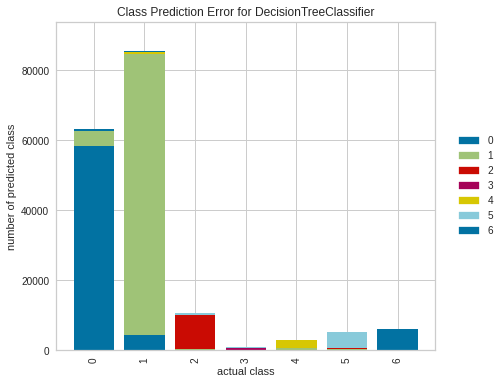

In [250]:
plot_model(models_both[0], plot='error')

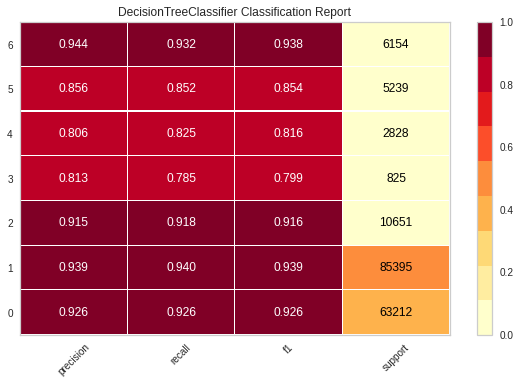

In [251]:
plot_model(models_both[0], plot='class_report')

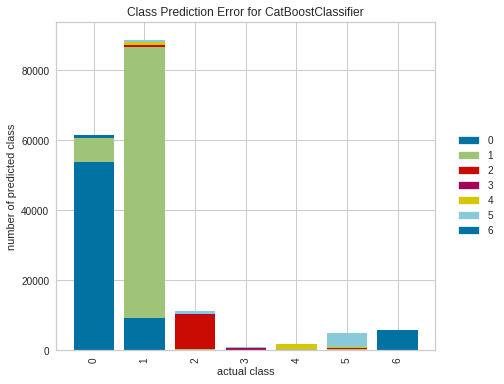

In [252]:
plot_model(models_both[1], plot='error')

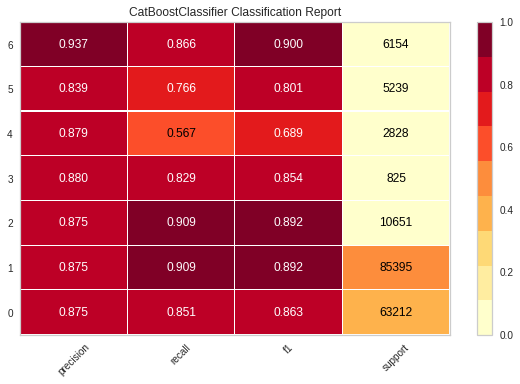

In [253]:
plot_model(models_both[1], plot='class_report')

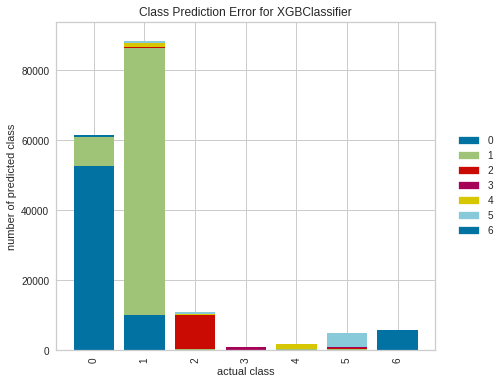

In [254]:
plot_model(models_both[2], plot='error')

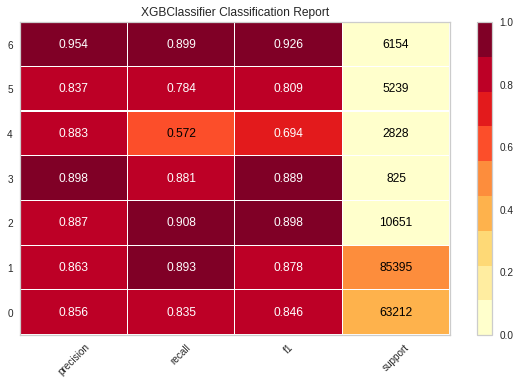

In [255]:
plot_model(models_both[2], plot='class_report')

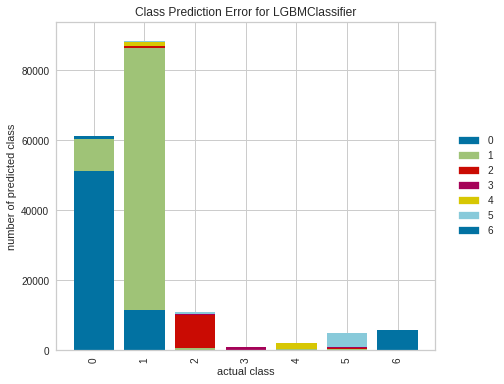

In [256]:
plot_model(models_both[3], plot='error')

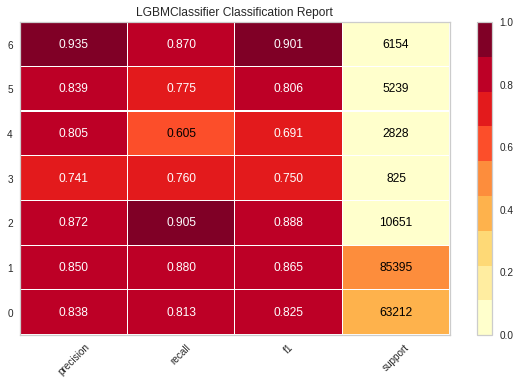

In [257]:
plot_model(models_both[3], plot='class_report')

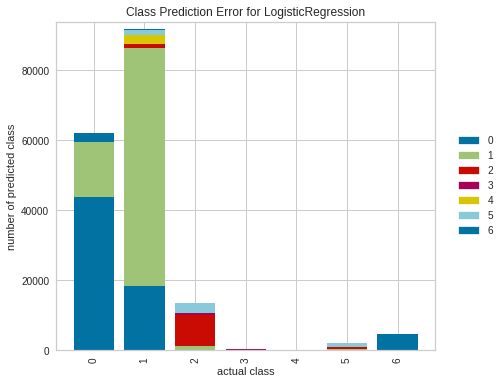

In [258]:
plot_model(models_both[4], plot='error')

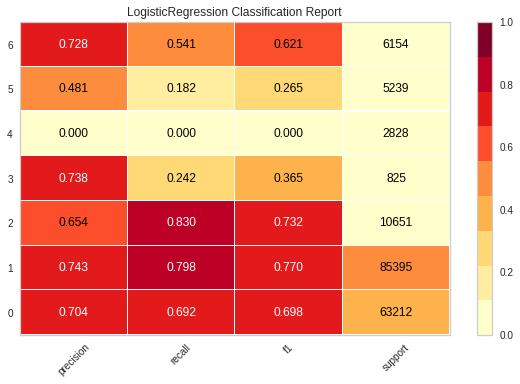

In [259]:
plot_model(models_both[4], plot='class_report')

# pickle result dataframes
### need `protocol=4` to read on local machine (default=5)
https://docs.python.org/3/library/pickle.html

In [260]:
df_pycaret_model_metrics.to_pickle(pycaret_results_dir + 'soil_df_pycaret_model_metrics.pkl')
df_report_by_class.to_pickle(pycaret_results_dir + 'soil_df_report_by_class.pkl')
df_report_summary.to_pickle(pycaret_results_dir + 'soil_df_report_summary.pkl')

In [263]:
df_pycaret_model_metrics.to_pickle(pycaret_results_dir + 'soil_df_pycaret_model_metrics_p4.pkl', protocol=4)
df_report_by_class.to_pickle(pycaret_results_dir + 'soil_df_report_by_class_p4.pkl', protocol=4)
df_report_summary.to_pickle(pycaret_results_dir + 'soil_df_report_summary_p4.pkl',   protocol=4)

# CONCLUSIONS